# Разведочный анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
data = pd.read_csv('ST14000NM001G.csv')

In [4]:
data.head()

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-11-14,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24064.0
1,2020-11-15,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34512.0
2,2020-11-16,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37440.0
3,2020-11-17,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40368.0
4,2020-11-18,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51392.0


## Статистики

Как видим, в датасете представлена только одна модель и 10927 различных дисков

Т.о. столбец ```model``` далее можно не использовать

In [5]:
(
    data
    .groupby('model', as_index=False)
    .agg(serial_numbers=('serial_number', 'nunique'))
)

,model,serial_numbers
0,ST14000NM001G,10927


Аналогично со столбцом ```capacity_bytes```, его тоже можно не использовать

In [6]:
(
    data
    .groupby('model', as_index=False)
    .agg(capacity_options=('capacity_bytes', 'nunique'))
)

,model,capacity_options
0,ST14000NM001G,1


In [7]:
cols = ['model', 'capacity_bytes']
data = data.drop(columns=cols) # удаляю ненужные столбцы

Количество дат, на которые имеем данные (глубина данных), отличается для каждого диска

In [8]:
data_depth_per_disk = (
    data
    .groupby('serial_number', as_index=False)
    .agg(dates_count=('date', 'nunique'))
)
data_depth_per_disk

,serial_number,dates_count
0,ZL201VZX,763
1,ZL2077KW,508
2,ZL2077NC,507
3,ZL209CRX,805
4,ZL20A2G8,823
...,...,...
10922,ZTM094RF,520
10923,ZTM094V6,507
10924,ZTM0952D,520
10925,ZTM096B0,521


Глубина данных варьируется от 1-го до 827-ми дней

In [9]:
(
    data_depth_per_disk
    .agg(
        min_depth=('dates_count', 'min'),
        max_depth=('dates_count', 'max')
    )
)

,dates_count
min_depth,1
max_depth,827


In [10]:
data_depth_per_disk.sort_values('dates_count')

,serial_number,dates_count
4054,ZL2N88VG,1
2081,ZL2CLE1S,5
4043,ZL2MGQQS,8
4045,ZL2MH6QG,8
3966,ZL2E7ET6,8
...,...,...
5216,ZLW17SF1,827
6036,ZLW18EG5,827
7448,ZLW18PM0,827
5865,ZLW18E89,827


Большинство дисков имеют глубину от 500-т дней (97.8%)

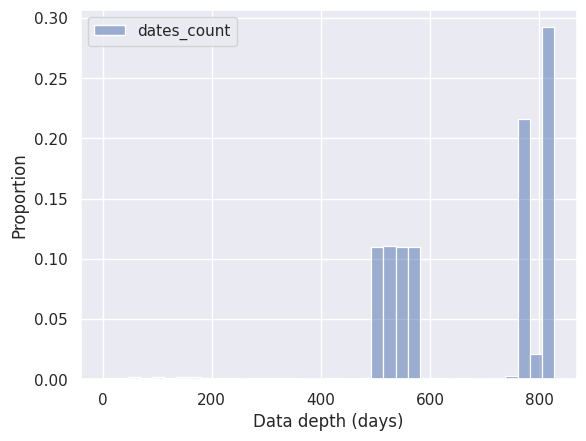

In [11]:
sns.histplot(data_depth_per_disk, stat='proportion')
plt.xlabel('Data depth (days)')
plt.show()

Так как прогнозируем вероятность сбоя в следующие 30 дней, оставим только те диски, по которым имеются данные хотя бы на 2*30=60 дней (их 99.7%)

In [12]:
elim_disks = (
    data_depth_per_disk
    .query('dates_count < 60')
    ['serial_number']
    .tolist()
)
len(elim_disks)

33

In [13]:
data = data[~data['serial_number'].isin(elim_disks)]

У более 98% дисков ни разу не было сбоев, так что имеем дело с очень несбалансированным датасетом

In [14]:
failure_df = (
    data
    .groupby('serial_number', as_index=False)
    .agg(failure=('failure', 'nunique'))
)
failure_df['has_failed'] = failure_df['failure'] > 1

failure_df[~failure_df['has_failed']].shape[0] / failure_df.shape[0]

0.9845786671562328

Посмотрим, есть ли пропущенные дни в данных

Для этого к первой дате прибавим глубину (в днях) и сравним с последней датой

In [15]:
def move_the_date(date: str, days: int) -> str:
    """
    Сдвигаем дату на столько дней, чтобы период, 
    начинающийся в date и заканчивающийся в полученную дату, 
    составлял days дней

    Параметры:
    ----------
        date (str): дата начала периода
        days (int): длина периода в днях (включая конец)

    Возвращает:
    -----------
        end_date (str): дата конца периода
    """
    end_date = pd.to_datetime(date) + pd.DateOffset(days=days-1)
    return end_date.strftime("%Y-%m-%d")

In [16]:
missing_days_df = (
    data
    .groupby('serial_number', as_index=False)
    .agg(
        min_date=('date', 'min'),
        max_date=('date', 'max'),
        dates_count=('date', 'count')
    )
)
missing_days_df['estimated_end'] = missing_days_df.apply(lambda row: move_the_date(row['min_date'], row['dates_count']), axis=1)

In [17]:
missing_days_df.query('max_date >= estimated_end').shape[0] / missing_days_df.shape[0]

1.0

Пропущенные дни есть для каждого диска!

Посмотрим, насколько их много

In [18]:
missing_days_count = (
    missing_days_df
    [['max_date', 'estimated_end']]
    .apply(pd.to_datetime)
    .apply(lambda row: row['max_date'] - row['estimated_end'], axis=1)
    .dt.days
    .tolist()
)
missing_days_df['days_missing'] = missing_days_count

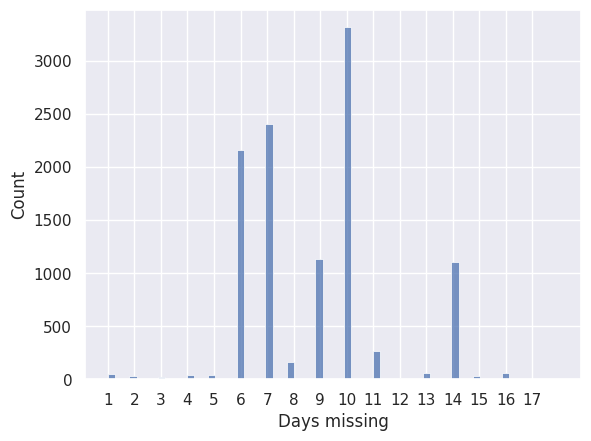

In [19]:
sns.histplot(missing_days_count)
plt.xticks(range(min(missing_days_count), max(missing_days_count), 1))
plt.xlabel('Days missing')
plt.show()

In [20]:
missing_days_df['proportion'] = missing_days_df['days_missing'] / missing_days_df['dates_count'] # доля пропущенных дней относительно имеющихся
(
    missing_days_df
    .sort_values('proportion', ascending=False)
    .head()
)

,serial_number,min_date,max_date,dates_count,estimated_end,days_missing,proportion
1496,ZL2CBG30,2021-08-04,2022-06-25,311,2022-06-10,15,0.048232
7910,ZLW18QBR,2020-11-15,2021-04-25,155,2021-04-18,7,0.045161
4284,ZLW15TD7,2020-11-14,2021-05-01,162,2021-04-24,7,0.043210
7101,ZLW18P6P,2020-11-14,2021-05-05,166,2021-04-28,7,0.042169
4631,ZLW16QQV,2020-11-15,2021-05-08,168,2021-05-01,7,0.041667


Т.к. их не более 5% от имеющихся по каждому диску, данные за эти дни можно аппроксимировать

Посчитаем количество сбоев на диск (по тем дискам, у которых они были)

In [21]:
(
    data
    .query('failure == 1')
    .groupby('serial_number', as_index=False)
    .agg(failures=('date', 'count'))
    .sort_values('failures', ascending=False)
)

,serial_number,failures
0,ZL25PMF9,1
115,ZLW18ESK,1
107,ZLW18EKF,1
108,ZLW18EKT,1
109,ZLW18ELV,1
...,...,...
57,ZLW17SF6,1
58,ZLW17SFE,1
59,ZLW17SFM,1
60,ZLW17SGG,1


Как видим, для каждого такого диска есть информация только про один сбой

Причем дата сбоя -- последняя дата в датасете почти для всех дисков

In [22]:
(
    data
    .query('failure == 1')
    .merge(missing_days_df, on='serial_number', how='left')
    [['date', 'serial_number', 'max_date']]
    .query('date < max_date') # после сбоев есть данные
)

,date,serial_number,max_date
92,2022-05-13,ZLW18EBF,2022-05-14
117,2022-07-25,ZLW18ETK,2022-07-26
144,2022-02-04,ZLW18Q3E,2022-02-06


In [23]:
(
    data
    .query('serial_number == "ZLW18Q3E"')
    .tail()
)

,date,serial_number,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
5111043,2022-02-01,ZLW18Q3E,0,32.0,11321.0,3.0,0.0,2.0,0.0,0.0,0.0,10778.0,7.027723e+10,1.884075e+11
5111044,2022-02-02,ZLW18Q3E,0,32.0,11352.0,3.0,0.0,2.0,0.0,0.0,0.0,10809.0,7.028328e+10,1.892781e+11
5111045,2022-02-03,ZLW18Q3E,0,32.0,11368.0,3.0,0.0,2.0,0.0,0.0,0.0,10825.0,7.028597e+10,1.907435e+11
5111046,2022-02-04,ZLW18Q3E,1,32.0,11400.0,3.0,0.0,2.0,0.0,0.0,0.0,10856.0,7.029597e+10,1.930312e+11
5111047,2022-02-06,ZLW18Q3E,0,32.0,11415.0,3.0,0.0,2.0,0.0,0.0,0.0,10872.0,7.030301e+10,1.939502e+11


## Признаки

Что означают столбцы:
1. **smart_5_raw** (Reallocated Sectors Count) - общее количество переназначенных секторов; рост свидетельствует об ухудшении
2. **smart_9_raw** (Power-on Time Count) - число часов, проведённых во включенном состоянии; в качестве порогового значения для него выбирается паспортное время наработки на отказ (MTBF — mean time between failure), для данной модели это 2.5 млн часов, но в датасете больше 20500 часов не бывает
3. **smart_187_raw** (Reported UNC Errors) - количество ошибок, которое накопитель сообщил хосту (интерфейсу компьютера) при любых операциях
4. **smart_188_raw** (Command Timeout) - количество прерванных операций в связи с таймаутом HDD; обычно это значение атрибута должно быть равно нулю, и если значение гораздо выше нуля, то, скорее всего, имеются серьёзные проблемы с питанием или окислением контактов кабелей передачи данных
5. **smart_192_raw** (Power-off retract count) - число циклов выключений или аварийных отказов (включений/выключений питания накопителя)
6. **smart_197_raw** (Current Pending Sector Count) - число секторов, являющихся кандидатами на замену (они ещё не были определены как плохие, но считывание с них отличается от чтения стабильного сектора — это так называемые подозрительные, или нестабильные сектора); в случае успешного последующего прочтения сектора он исключается из числа кандидатов; в случае повторных ошибочных чтений накопитель пытается восстановить его и выполняет операцию переназначения (remapping); рост значения этого атрибута может свидетельствовать о физической деградации жёсткого диска
7. **smart_198_raw** (Uncorrectable Sector Count) - число некорректируемых (средствами диска) секторов; в случае увеличения числа ошибок велика вероятность критических дефектов поверхности и/или механики накопителя
8. **smart_199_raw** (SATA R-Errors Error Count) - число ошибок при приёме и передаче данных по интерфейсу
9. **smart_240_raw** (Head flying hours) - общее время нахождения блока головок в рабочем положении в часах
10. **smart_241_raw** (Total LBAs Written) - полное число записанных секторов
11. **smart_242_raw** (Total LBAs Read) - полное число прочитанных секторов

In [24]:
import random

random.seed(32)

In [25]:
failed_disks = (
    data
    .query('failure == 1')
    ['serial_number']
    .tolist()
)

failed = data[data['serial_number'].isin(failed_disks)] 
other = data[~data['serial_number'].isin(failed_disks)]

In [26]:
failed_sample = random.sample(failed_disks, 8)
other_sample = random.sample(list(set(other['serial_number'])), 8)

### 1. smart_5_raw

Как видим ниже, у некоторых дисков со сбоями smart_5_raw растёт, а у дисков без сбоев держится на нуле, поэтому можно в качестве признака взять площадь под соответствующим периоду графиком 

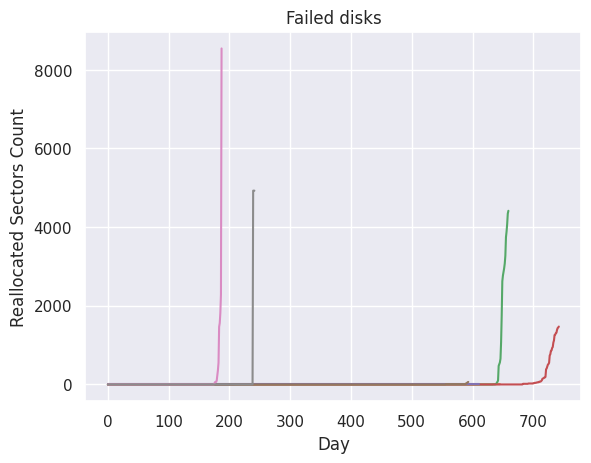

In [26]:
for disk in failed_sample:
    smart_5 = (
        data
        .query('serial_number == @disk')
        ['smart_5_raw']
        .tolist()
    )
    plt.plot(smart_5)
    plt.xlabel('Day')
    plt.ylabel('Reallocated Sectors Count')
    plt.title('Failed disks')

plt.show()

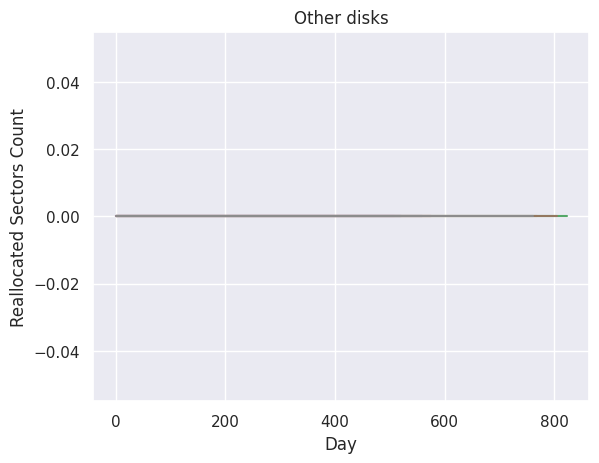

In [27]:
for disk in other_sample:
    smart_5 = (
        data
        .query('serial_number == @disk')
        ['smart_5_raw']
        .tolist()
    )
    plt.plot(smart_5)
    plt.xlabel('Day')
    plt.ylabel('Reallocated Sectors Count')
    plt.title('Other disks')

plt.show()

### 2. smart_9_raw

Как и ожидалось, число часов, проведённых во включенном состоянии, растёт линейно с датой, поэтому в качестве признака подойдёт разве что максимальное значение этого параметра на рассматриваемом периоде

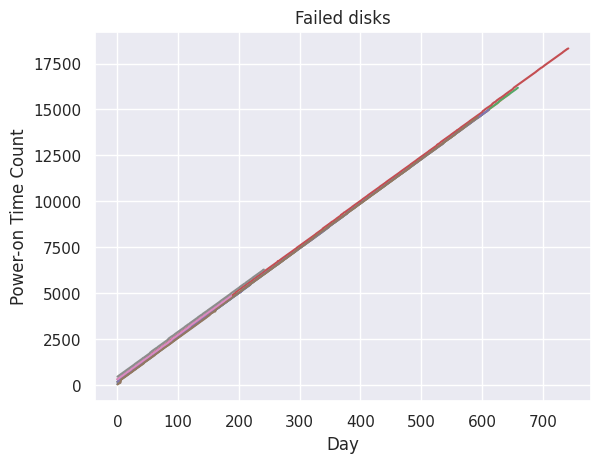

In [28]:
for disk in failed_sample:
    smart_9 = (
        data
        .query('serial_number == @disk')
        ['smart_9_raw']
        .tolist()
    )
    plt.plot(smart_9)
    plt.xlabel('Day')
    plt.ylabel('Power-on Time Count')
    plt.title('Failed disks')

plt.show()

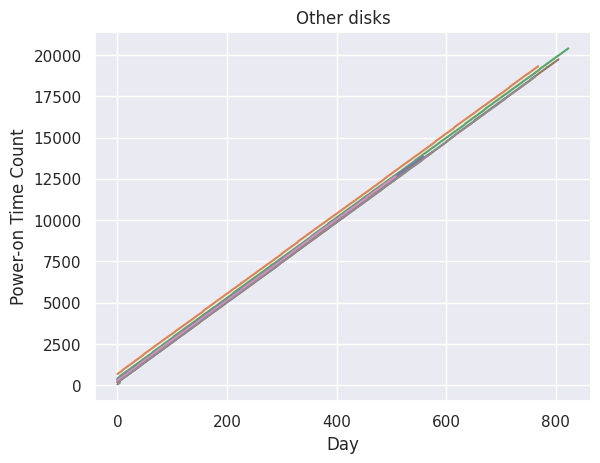

In [29]:
for disk in other_sample:
    smart_9 = (
        data
        .query('serial_number == @disk')
        ['smart_9_raw']
        .tolist()
    )
    plt.plot(smart_9)
    plt.xlabel('Day')
    plt.ylabel('Power-on Time Count')
    plt.title('Other disks')

plt.show()

### 3. smart_187_raw

Аналогично ```smart_5_raw```, в качестве признака можно взять площадь под соответствующим периоду графиком

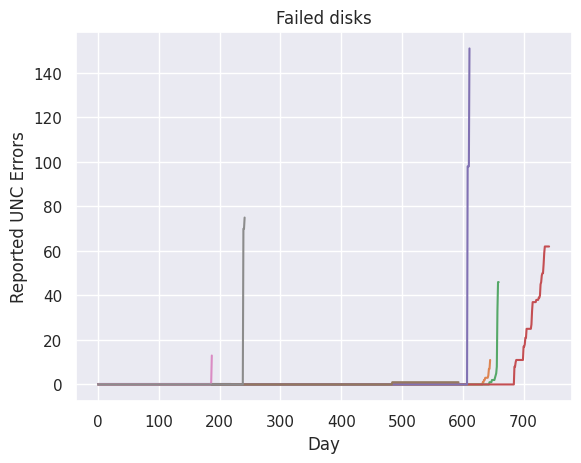

In [30]:
for disk in failed_sample:
    smart_187 = (
        data
        .query('serial_number == @disk')
        ['smart_187_raw']
        .tolist()
    )
    plt.plot(smart_187)
    plt.xlabel('Day')
    plt.ylabel('Reported UNC Errors')
    plt.title('Failed disks')

plt.show()

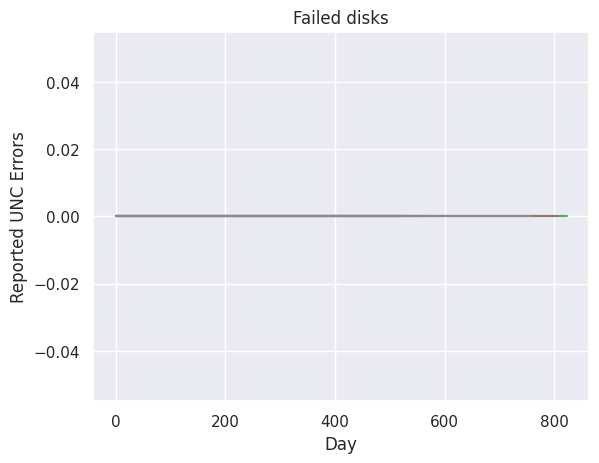

In [31]:
for disk in other_sample:
    smart_187 = (
        data
        .query('serial_number == @disk')
        ['smart_187_raw']
        .tolist()
    )
    plt.plot(smart_187)
    plt.xlabel('Day')
    plt.ylabel('Reported UNC Errors')
    plt.title('Failed disks')

plt.show()

### 4. smart_188_raw

В качестве признака можно взять максимальное значение этого параметра на рассматриваемом периоде

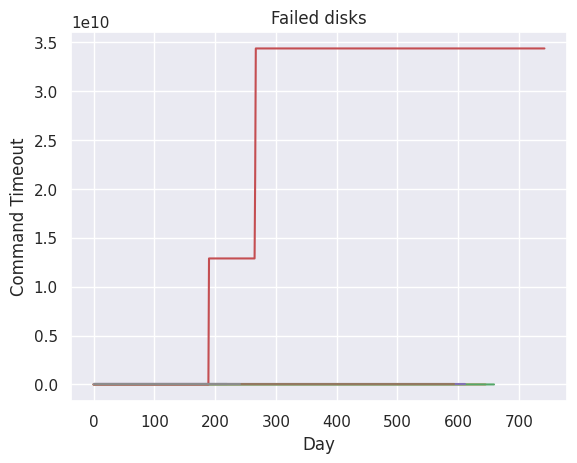

In [32]:
for disk in failed_sample:
    smart_188 = (
        data
        .query('serial_number == @disk')
        ['smart_188_raw']
        .tolist()
    )
    plt.plot(smart_188)
    plt.xlabel('Day')
    plt.ylabel('Command Timeout')
    plt.title('Failed disks')

plt.show()

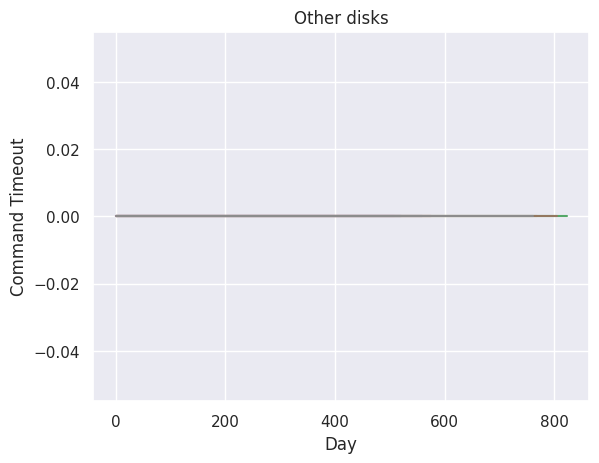

In [33]:
for disk in other_sample:
    smart_188 = (
        data
        .query('serial_number == @disk')
        ['smart_188_raw']
        .tolist()
    )
    plt.plot(smart_188)
    plt.xlabel('Day')
    plt.ylabel('Command Timeout')
    plt.title('Other disks')

plt.show()

### 5. smart_192_raw

Характеристика сама по себе не помогает прогнозировать сбой

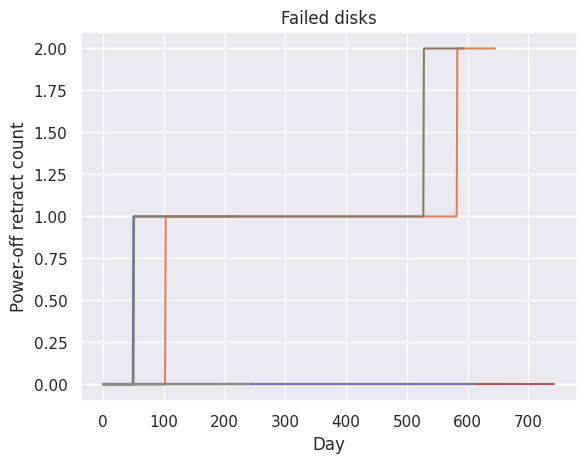

In [34]:
for disk in failed_sample:
    smart_192 = (
        data
        .query('serial_number == @disk')
        ['smart_192_raw']
        .tolist()
    )
    plt.plot(smart_192)
    plt.xlabel('Day')
    plt.ylabel('Power-off retract count')
    plt.title('Failed disks')

plt.show()

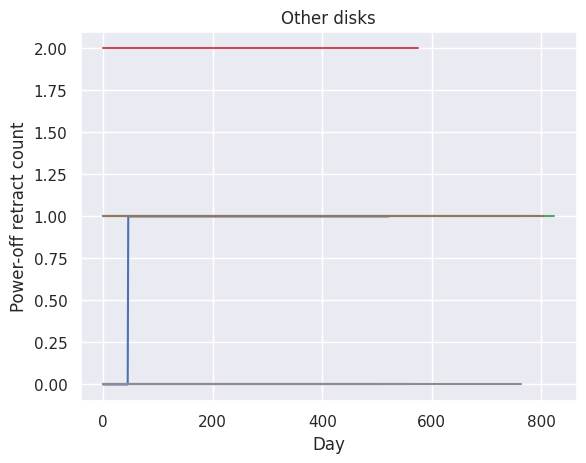

In [35]:
for disk in other_sample:
    smart_192 = (
        data
        .query('serial_number == @disk')
        ['smart_192_raw']
        .tolist()
    )
    plt.plot(smart_192)
    plt.xlabel('Day')
    plt.ylabel('Power-off retract count')
    plt.title('Other disks')

plt.show()

Посмотрим на распределение значений smart_192_raw для дисков со сбоем

In [36]:
# 99% значений < 40, поэтому для удобства отображаю на гистограмме только их
failed.query('(failure == 1)&(smart_192_raw < 40)').shape[0] / failed.query('failure == 1').shape[0]

0.9940476190476191

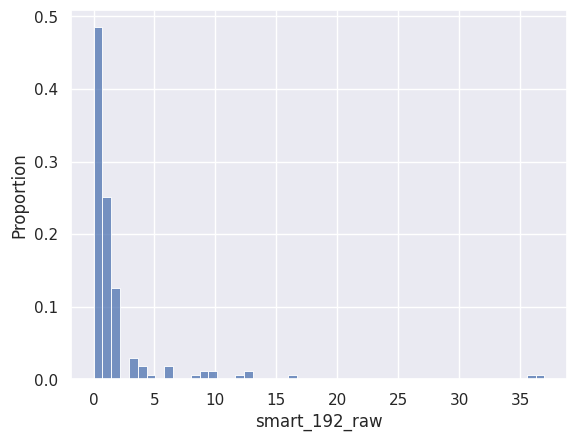

In [37]:
sns.histplot(failed.query('(failure == 1)&(smart_192_raw < 40)')['smart_192_raw'], stat='proportion')
plt.show()

Аналогично для дисков без сбоя

In [38]:
# здесь тоже 99% значений < 40
(
    other
    .merge(
        missing_days_df,
        on='serial_number',
        how='left'
    )
    .query('(date == max_date)&(smart_192_raw < 40)')
    .shape[0]
) / (
    other
    .merge(
        missing_days_df,
        on='serial_number',
        how='left'
    )
    .query('date == max_date')
    .shape[0]
)

0.9909565541674435

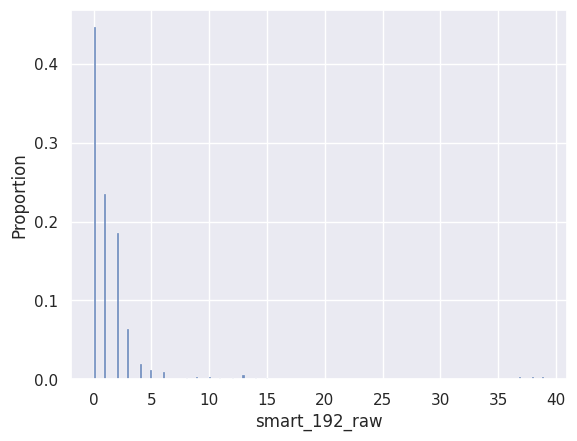

In [39]:
l = (
    other
    .merge(
        missing_days_df,
        on='serial_number',
        how='left'
    )
    .query('(date == max_date)&(smart_192_raw < 40)')
    ['smart_192_raw']
)
sns.histplot(l, stat='proportion')
plt.show()

In [40]:
max_failed = (
    failed
    .query('failure == 1')[
    'smart_192_raw']
    .max()
)
max_other = (
    other
    .merge(
        missing_days_df,
        on='serial_number',
        how='left'
    )
    .query('date == max_date')
    ['smart_192_raw']
    .max()
)

print('max(smart_192_raw) for failed disks: ', max_failed)
print('max(smart_192_raw) for other disks: ', max_other)

max(smart_192_raw) for failed disks:  505.0
max(smart_192_raw) for other disks:  6327.0


Итак, распределения очень похожи, но максимумы кратно отличаются

Пока непонятно, как её использовать

Можно попробовать сдвинуть значения, вычтя из каждого то, что было на момент начала периода

### 6. smart_197_raw

В качестве признака можно взять площадь под соответствующим периоду графиком

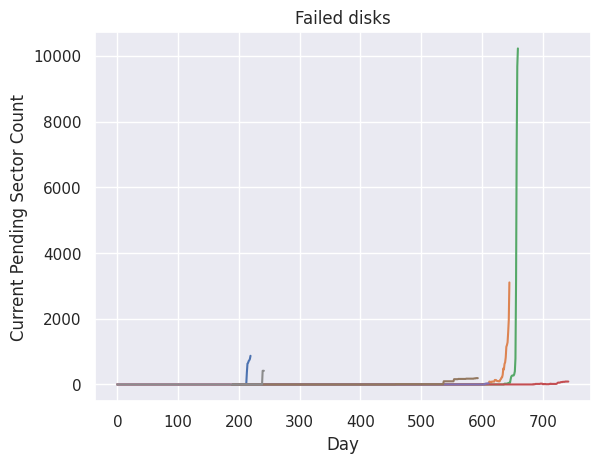

In [41]:
for disk in failed_sample:
    smart_197 = (
        data
        .query('serial_number == @disk')
        ['smart_197_raw']
        .tolist()
    )
    plt.plot(smart_197)
    plt.xlabel('Day')
    plt.ylabel('Current Pending Sector Count')
    plt.title('Failed disks')

plt.show()

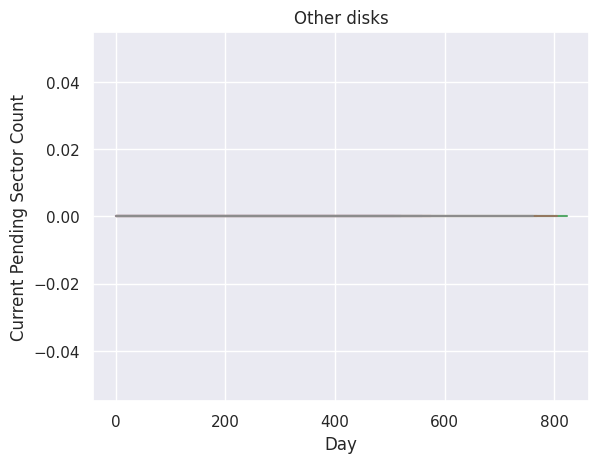

In [42]:
for disk in other_sample:
    smart_197 = (
        data
        .query('serial_number == @disk')
        ['smart_197_raw']
        .tolist()
    )
    plt.plot(smart_197)
    plt.xlabel('Day')
    plt.ylabel('Current Pending Sector Count')
    plt.title('Other disks')

plt.show()

### 7. smart_198_raw

Графики ниже подозрительно похожи на графики для ```smart_197_raw```

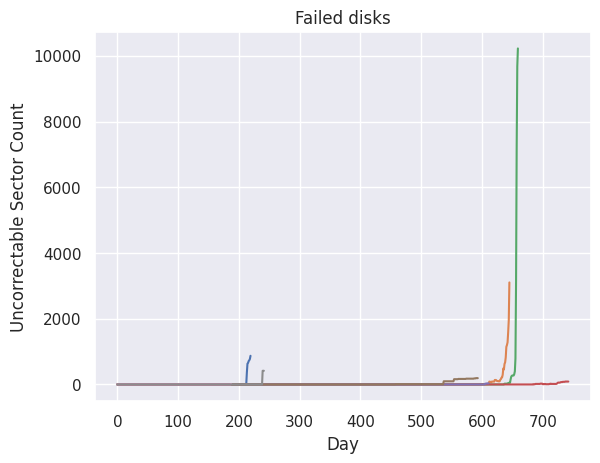

In [43]:
for disk in failed_sample:
    smart_198 = (
        data
        .query('serial_number == @disk')
        ['smart_198_raw']
        .tolist()
    )
    plt.plot(smart_198)
    plt.xlabel('Day')
    plt.ylabel('Uncorrectable Sector Count')
    plt.title('Failed disks')

plt.show()

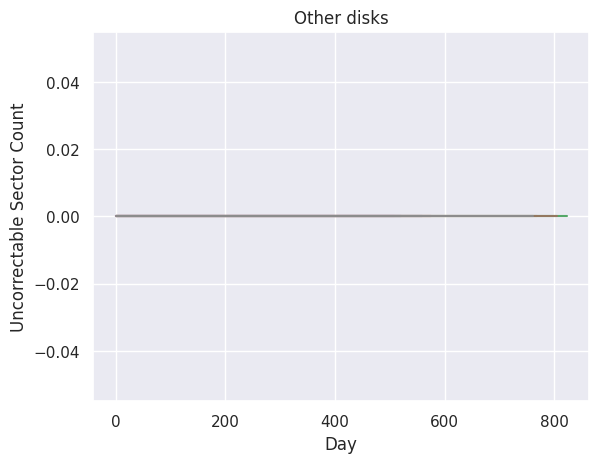

In [44]:
for disk in other_sample:
    smart_198 = (
        data
        .query('serial_number == @disk')
        ['smart_198_raw']
        .tolist()
    )
    plt.plot(smart_198)
    plt.xlabel('Day')
    plt.ylabel('Uncorrectable Sector Count')
    plt.title('Other disks')

plt.show()

На самом деле, значения этих характеристик в датасете совпадают полностью, поэтому можно оставить только одну из двух

In [54]:
sum(data['smart_197_raw'] != data['smart_198_raw'])

0

### 8. smart_199_raw

Большая часть дисков, как со сбоем, так и без, на протяжении всего периода (включая момент сбоя) имеет в этом показателе 0, хотя диски без сбоя чаще

Поэтому данная характеристика даёт мало информации, однако можно попробовать взять в качестве признака максимальное значение за период или сделать из неё бинарную переменную (является ли > 0 хоть в какой-то момент периода)

In [45]:
df = (
    failed
    .groupby('serial_number', as_index=False)
    .agg(max_199=('smart_199_raw', 'max'))
)
df[df['max_199']==0].shape[0] / df.shape[0]

0.8809523809523809

In [46]:
df2 = (
    other
    .groupby('serial_number', as_index=False)
    .agg(max_199=('smart_199_raw', 'max'))
)
df2[df2['max_199']==0].shape[0] / df2.shape[0]

0.9495618124184225

### 9. smart_240_raw

Судя по графикам ниже, не помогает прогнозировать сбой, т.к. они выглядят одинаково для дисков со сбоем и без

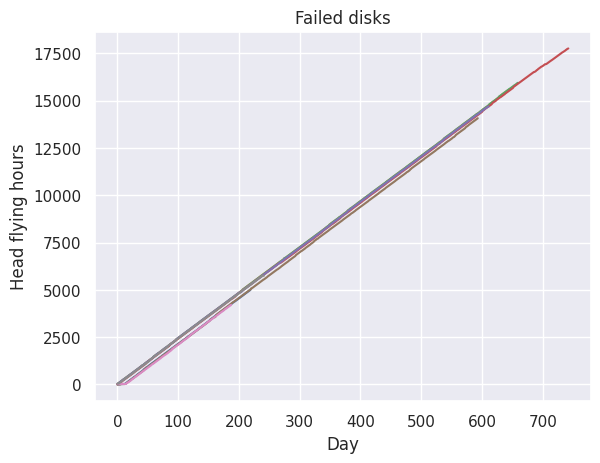

In [47]:
for disk in failed_sample:
    smart_240 = (
        data
        .query('serial_number == @disk')
        ['smart_240_raw']
        .tolist()
    )
    plt.plot(smart_240)
    plt.xlabel('Day')
    plt.ylabel('Head flying hours')
    plt.title('Failed disks')

plt.show()

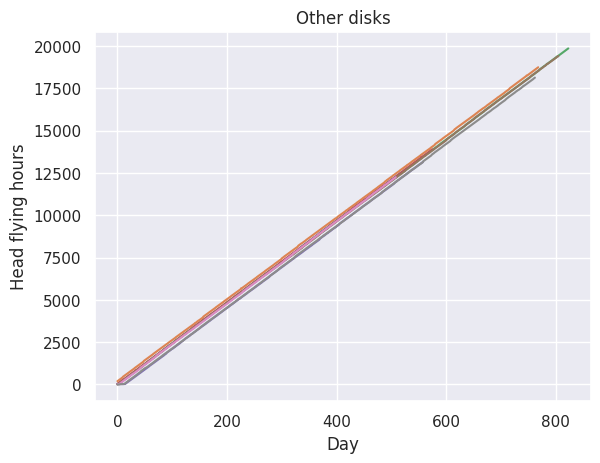

In [48]:
for disk in other_sample:
    smart_240 = (
        data
        .query('serial_number == @disk')
        ['smart_240_raw']
        .tolist()
    )
    plt.plot(smart_240)
    plt.xlabel('Day')
    plt.ylabel('Head flying hours')
    plt.title('Other disks')

plt.show()

### 10. smart_241_raw

Судя по графикам ниже, характеристика сама по себе не помогает прогнозировать сбой

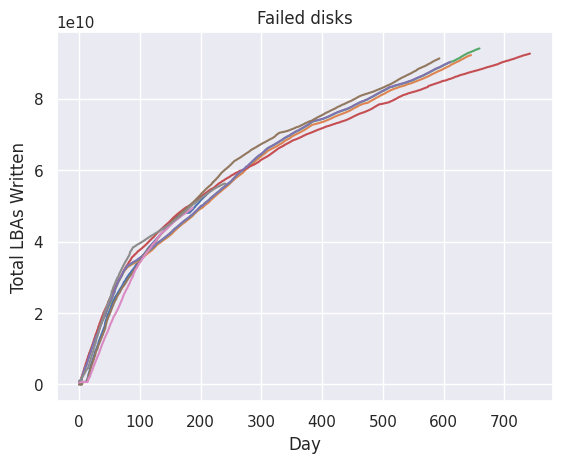

In [49]:
for disk in failed_sample:
    smart_241 = (
        data
        .query('serial_number == @disk')
        ['smart_241_raw']
        .tolist()
    )
    plt.plot(smart_241)
    plt.xlabel('Day')
    plt.ylabel('Total LBAs Written')
    plt.title('Failed disks')

plt.show()

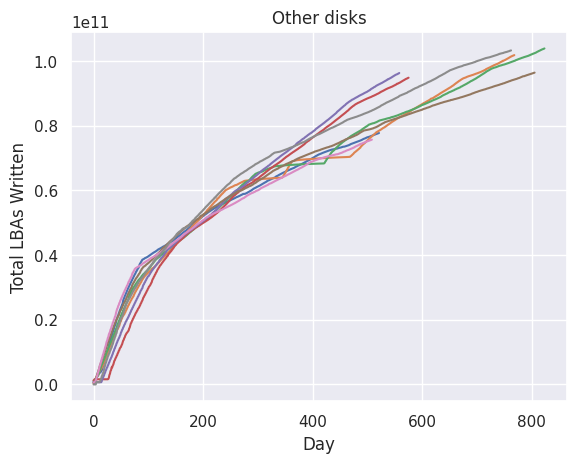

In [50]:
for disk in other_sample:
    smart_241 = (
        data
        .query('serial_number == @disk')
        ['smart_241_raw']
        .tolist()
    )
    plt.plot(smart_241)
    plt.xlabel('Day')
    plt.ylabel('Total LBAs Written')
    plt.title('Other disks')

plt.show()

### 11. smart_242_raw

Опять же, характеристика сама по себе не помогает прогнозировать сбой

Можно попытаться как-то скомбинировать её с предыдущей (например, взять частное)

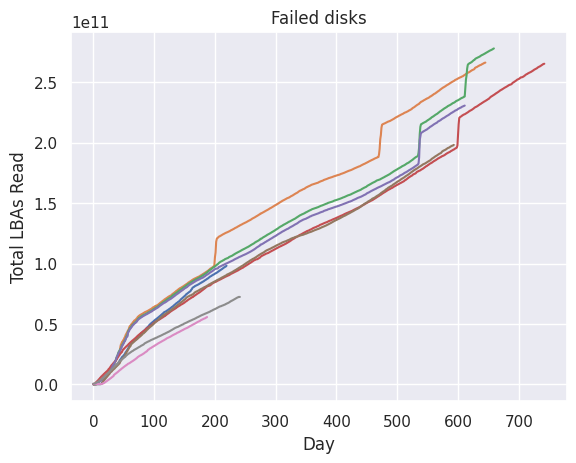

In [51]:
for disk in failed_sample:
    smart_242 = (
        data
        .query('serial_number == @disk')
        ['smart_242_raw']
        .tolist()
    )
    plt.plot(smart_242)
    plt.xlabel('Day')
    plt.ylabel('Total LBAs Read')
    plt.title('Failed disks')

plt.show()

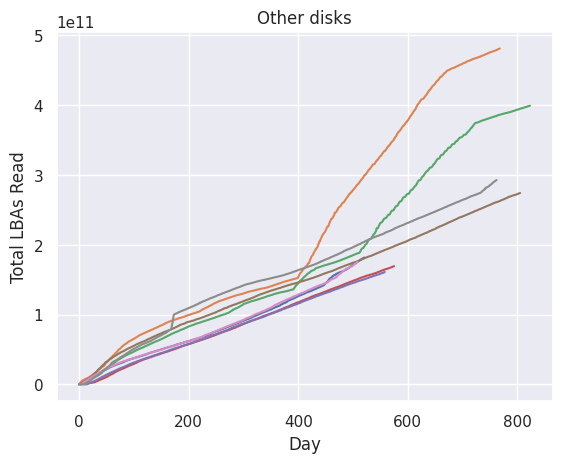

In [52]:
for disk in other_sample:
    smart_242 = (
        data
        .query('serial_number == @disk')
        ['smart_242_raw']
        .tolist()
    )
    plt.plot(smart_242)
    plt.xlabel('Day')
    plt.ylabel('Total LBAs Read')
    plt.title('Other disks')

plt.show()

## Sanity Checks

Дней, аномальных по количеству сбоев, нет

31 раз были сбои 155-ти (каждый раз разных) дисков

In [40]:
(
    failed
    .groupby('date', as_index=False)
    .agg(disks_failed=('serial_number', 'count'))
    .groupby('disks_failed', as_index=False)
    .agg(n_times=('date', 'count'))
    .sort_values('disks_failed', ascending=False)
)

,disks_failed,n_times
140,155,31
139,154,29
138,153,11
137,152,2
136,151,22
...,...,...
4,5,3
3,4,1
2,3,2
1,2,2
